# Intro
Let's compare the outputs from the simulated workloads as processed separately by multi-processes and threads.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_in_data(output_file, resample_window = "10s"):
    df = pd.read_csv(output_file, parse_dates=["start", "end"], infer_datetime_format=True)
    total_duration = df["end"].max() - df["start"].min() 
    
    print(output_file)
    print("total duration:", total_duration)
    print()
    
    df = df.set_index("start")[["worker"]]
    df = df.groupby("worker").resample(resample_window).count()
    df.columns = ["occurances"]
    return df


In [3]:
def aggregate_data(df, group_by = ["start"]):
    sum_occurances_df = df.reset_index()
    sum_occurances_df = sum_occurances_df.groupby(group_by)[["occurances"]].sum()
    
    sum_occurances_df = sum_occurances_df.reset_index()
    min_time = sum_occurances_df["start"].min()
    sum_occurances_df["start"] = sum_occurances_df["start"].apply(lambda x: int((x - min_time).total_seconds()))
    sum_occurances_df = sum_occurances_df.set_index("start")
    
    if len(group_by) > 1:
        sum_occurances_df = sum_occurances_df.reset_index().pivot(index=group_by[0], columns=group_by[1:])
    
    return sum_occurances_df

In [4]:
def plot_agg_df(agg_dfs):
    fig, ax = plt.subplots(nrows=len(agg_dfs), ncols=1, sharex=True, sharey=True, figsize=(24, 16))
    
    for i, df in enumerate(agg_dfs):
        ax[i] = df.plot(kind="bar", rot=45, stacked=True, title="Tasks Started Per Worker", ax = ax[i])
        ax[i].legend(loc='upper left')
        ax[i].set_xlabel("Number of Tasks Started")
        ax[i].set_ylabel("Seconds Elapsed")

# Read In Data

In [5]:
resample_window = "20s"

In [6]:
mp_df = read_in_data("output/output-multiprocessing-pool-100000_workers-7_sleep-0_25.csv", resample_window = resample_window)
t_df = read_in_data("output/output-threads-100000_workers-7_sleep-0_25.csv", resample_window = resample_window)

output/output-multiprocessing-pool-100000_workers-7_sleep-0_25.csv
total duration: 0 days 00:18:02.913491

output/output-threads-100000_workers-7_sleep-0_25.csv
total duration: 0 days 00:17:57.421933



Between the two there's a difference of 5 seconds. Threads being marginally faster.

In [7]:
mp_agg_worker_df = aggregate_data(mp_df, ["start", "worker"])
t_agg_worker_df = aggregate_data(t_df, ["start", "worker"])

# Plots

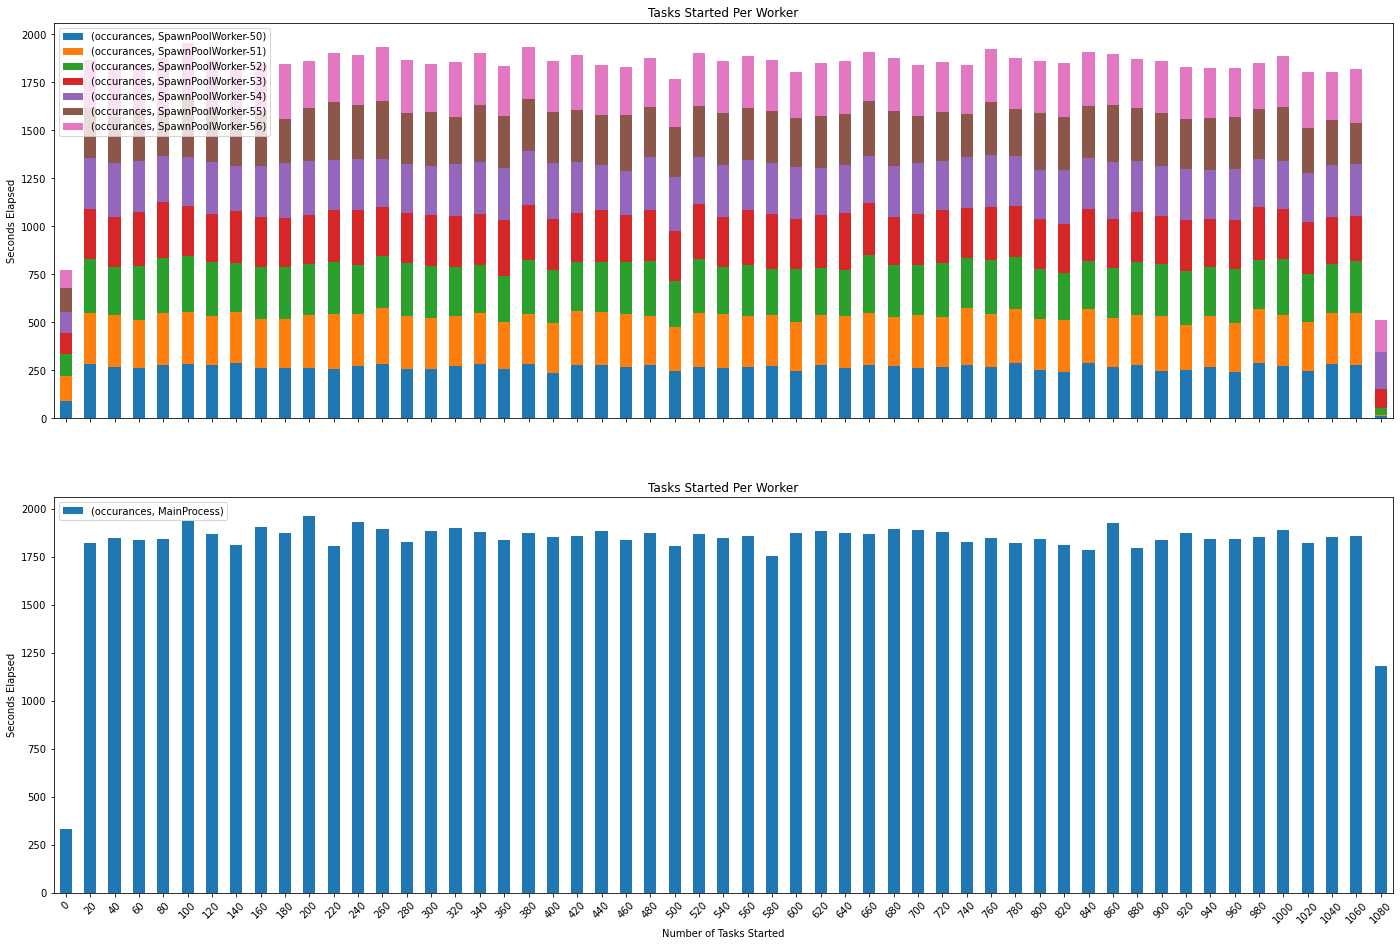

In [8]:
plot_agg_df([mp_agg_worker_df, t_agg_worker_df])

Seems like the mutli-processing approach landed up where the workload wasn't evenly distributed. Is this because the tasks be done are allocated ahead of time?

In [9]:
mp_agg_worker_df.apply(np.mean, axis=0)

            worker            
occurances  SpawnPoolWorker-50    259.781818
            SpawnPoolWorker-51    259.781818
            SpawnPoolWorker-52    259.781818
            SpawnPoolWorker-53    259.781818
            SpawnPoolWorker-54    259.490909
            SpawnPoolWorker-55    264.592593
            SpawnPoolWorker-56    259.781818
dtype: float64